## Predict evolution of tweet sentiment for each hashtag

In [10]:
import json
import pytz
from sklearn.metrics import auc, confusion_matrix, recall_score, roc_curve, precision_score, accuracy_score
from matplotlib import pyplot as plt
import itertools
from datetime import datetime, timedelta
from textblob import TextBlob
import regex as re
import numpy as np

pst_tz = pytz.timezone('America/Los_Angeles')

In [11]:
def cleanTweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def plot_num_tweets_per_hour(file_name, hashtag_name):  
    # Store the number of tweets in each hour
    hour_list = []
    
    # load the json object list    
    f = open(file_name, 'r', encoding = 'utf-8')
    
    for lineNum, line in enumerate(f) : 
        eachTweet = json.loads(line)
        post_time = eachTweet['citation_date']
        mdh = datetime.fromtimestamp(post_time, pst_tz).strftime("%m-%d-%H")
        hour_list.append(mdh)
        
        
    hour_list = np.unique(hour_list)
    # form a map, key: date, value: num of tweets
    positive_map = {i : 0 for i in hour_list}
    negative_map = {i : 0 for i in hour_list}
        
    f = open(file_name, 'r', encoding = 'utf-8')

    for lineNum, line in enumerate(f) :
        tweet = json.loads(line)
        post_time = tweet['citation_date']
        mdh = datetime.fromtimestamp(post_time, pst_tz).strftime("%m-%d-%H")
        
        tweet_text = tweet['tweet']['text']
        tweet_analysis = TextBlob(cleanTweet(tweet_text))
        sentiment = tweet_analysis.sentiment.polarity
        
        if sentiment > 0:
            positive_map[mdh] = positive_map[mdh] + 1
        elif sentiment < 0:
            negative_map[mdh] = negative_map[mdh] + 1
        
    f.close()
    
    # plot the figure
    plt.figure()
    plt.figure(figsize=(20,10))
    plt.bar(range(len(hour_list)), positive_map.values(), width=1)
    plt.xlabel('Hour')
    plt.ylabel('Number of positive tweets')
    plt.title(('Number of positive tweets per hour for ' + hashtag_name))
    plt.xticks([0,int(len(hour_list)/2),len(hour_list)],[hour_list[0],hour_list[int(len(hour_list)/2)-1],hour_list[len(hour_list)-1]])
    plt.show()
    
    plt.figure()
    plt.figure(figsize=(20,10))
    plt.bar(range(len(hour_list)), negative_map.values(), width=1)
    plt.xlabel('Hour')
    plt.ylabel('Number of negative tweets')
    plt.title(('Number of negative tweets per hour for ' + hashtag_name))
    plt.xticks([0,int(len(hour_list)/2),len(hour_list)],[hour_list[0],hour_list[int(len(hour_list)/2)-1],hour_list[len(hour_list)-1]]) 
    plt.show()

<Figure size 432x288 with 0 Axes>

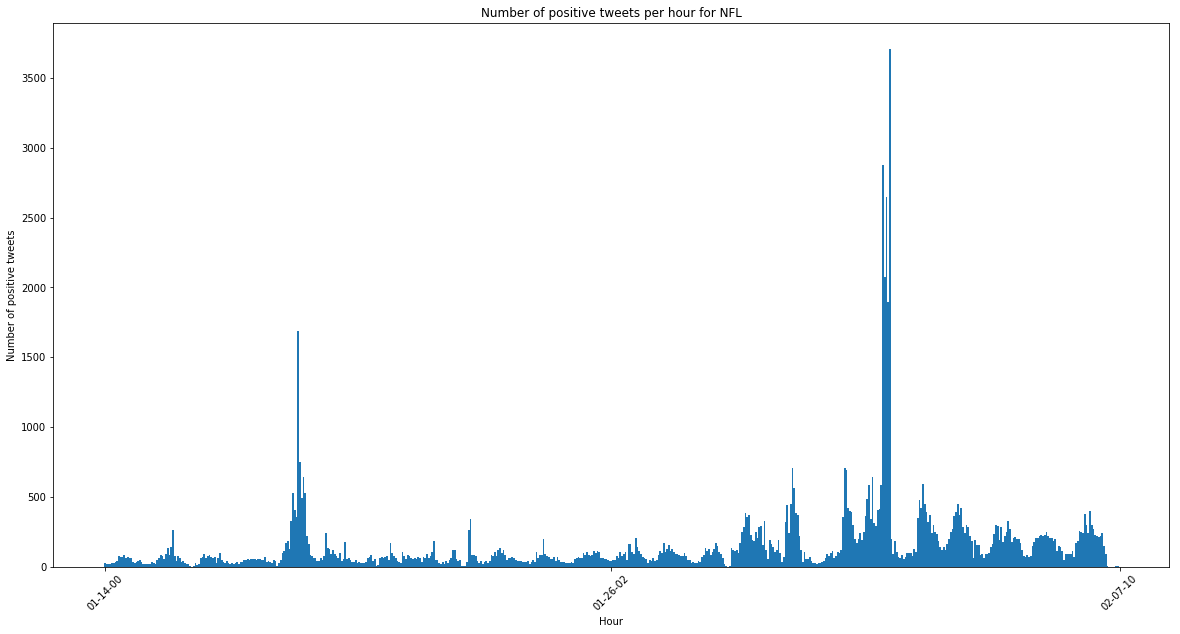

<Figure size 432x288 with 0 Axes>

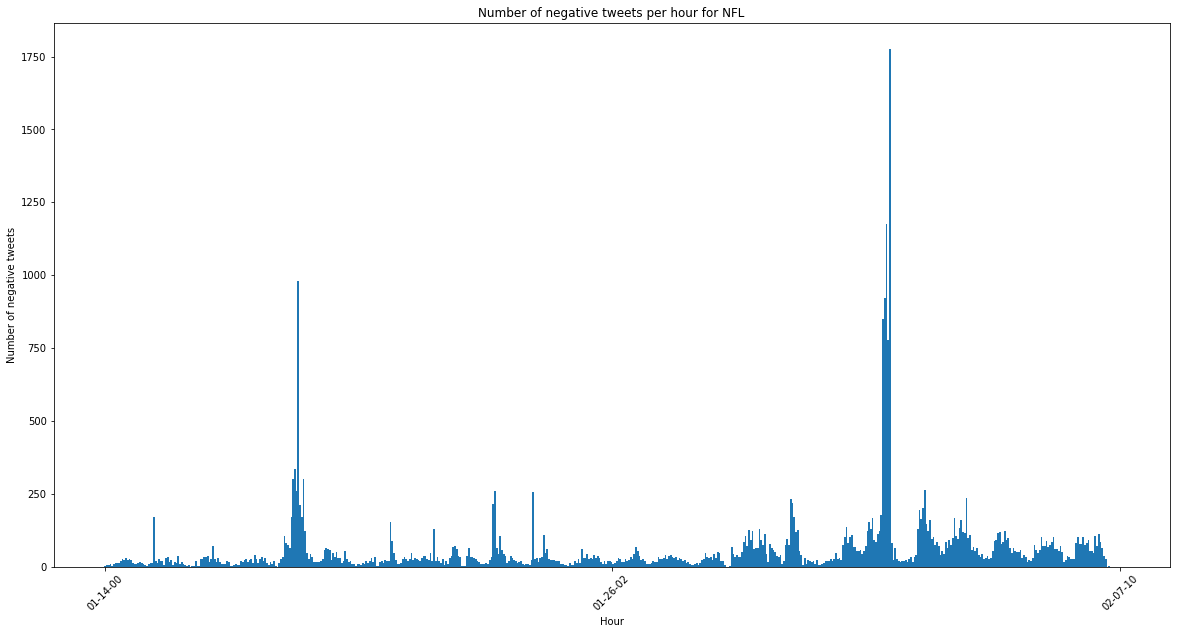

In [12]:
plot_num_tweets_per_hour('tweets_#nfl.txt', 'NFL')

<Figure size 432x288 with 0 Axes>

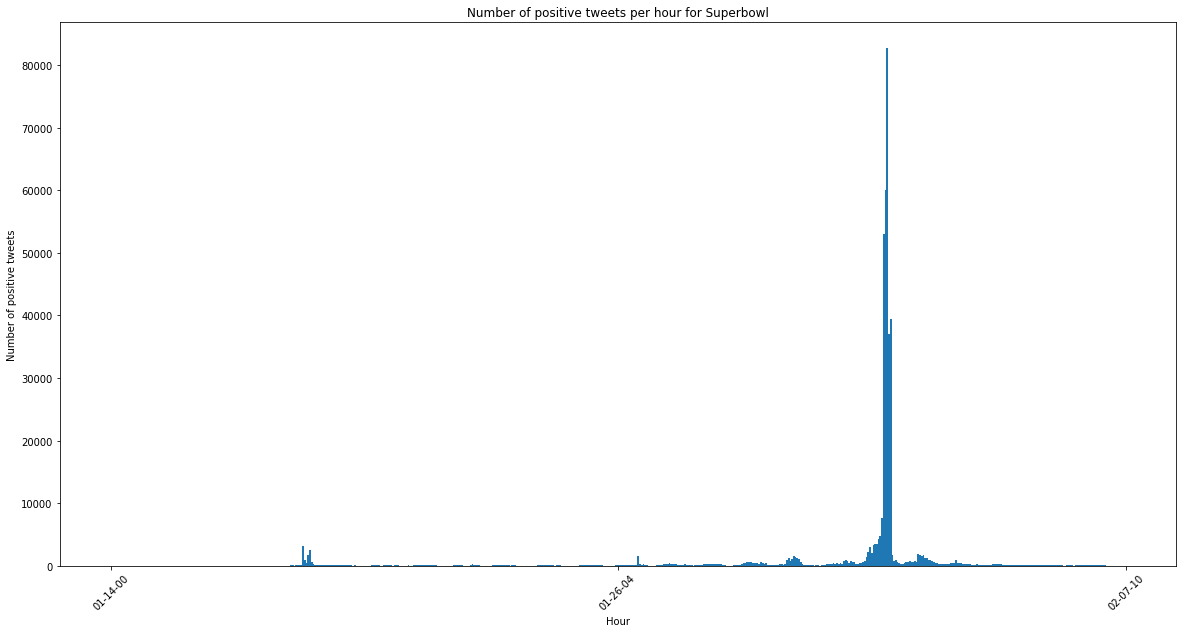

<Figure size 432x288 with 0 Axes>

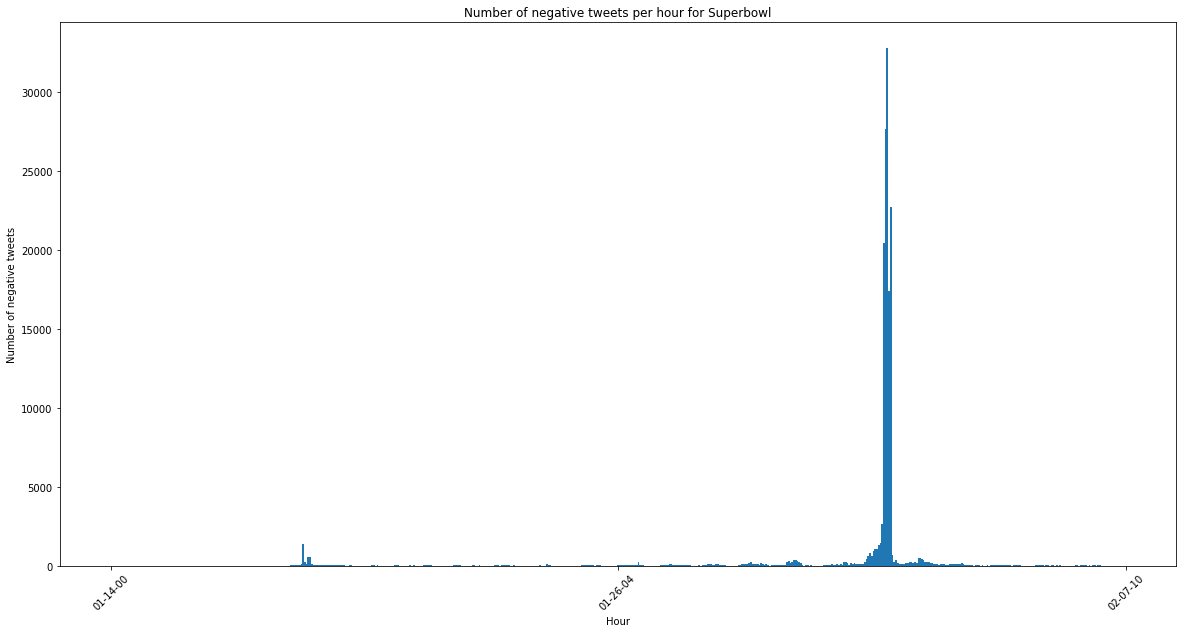

In [13]:
plot_num_tweets_per_hour('tweets_#superbowl.txt', 'Superbowl')

<Figure size 432x288 with 0 Axes>

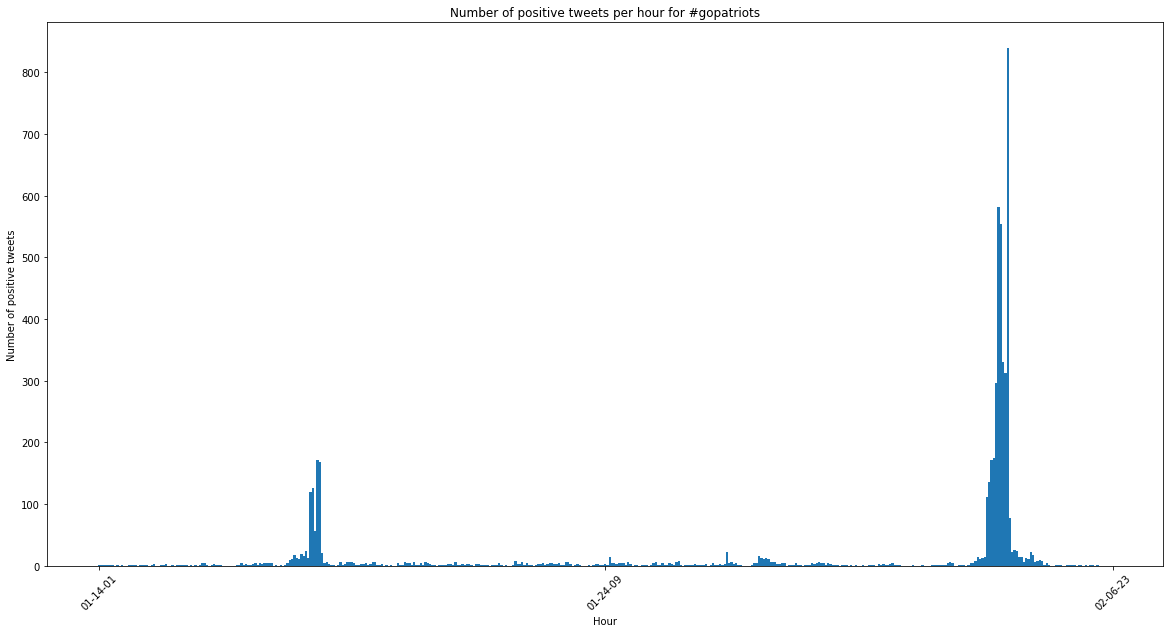

<Figure size 432x288 with 0 Axes>

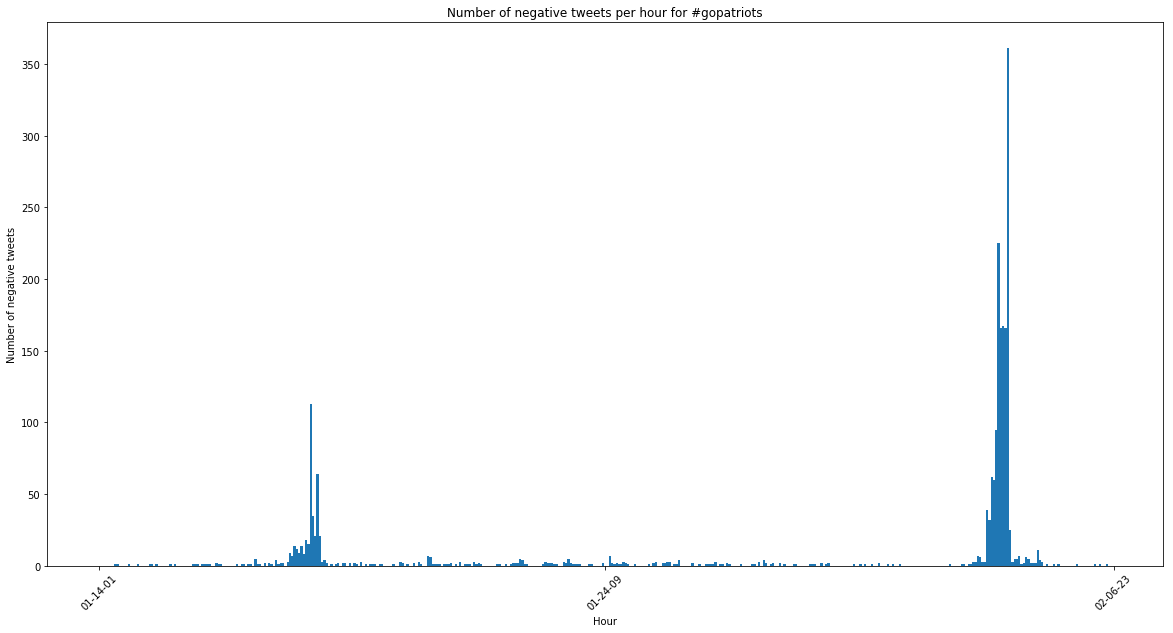

In [14]:
plot_num_tweets_per_hour('tweets_#gopatriots.txt', '#gopatriots')

<Figure size 432x288 with 0 Axes>

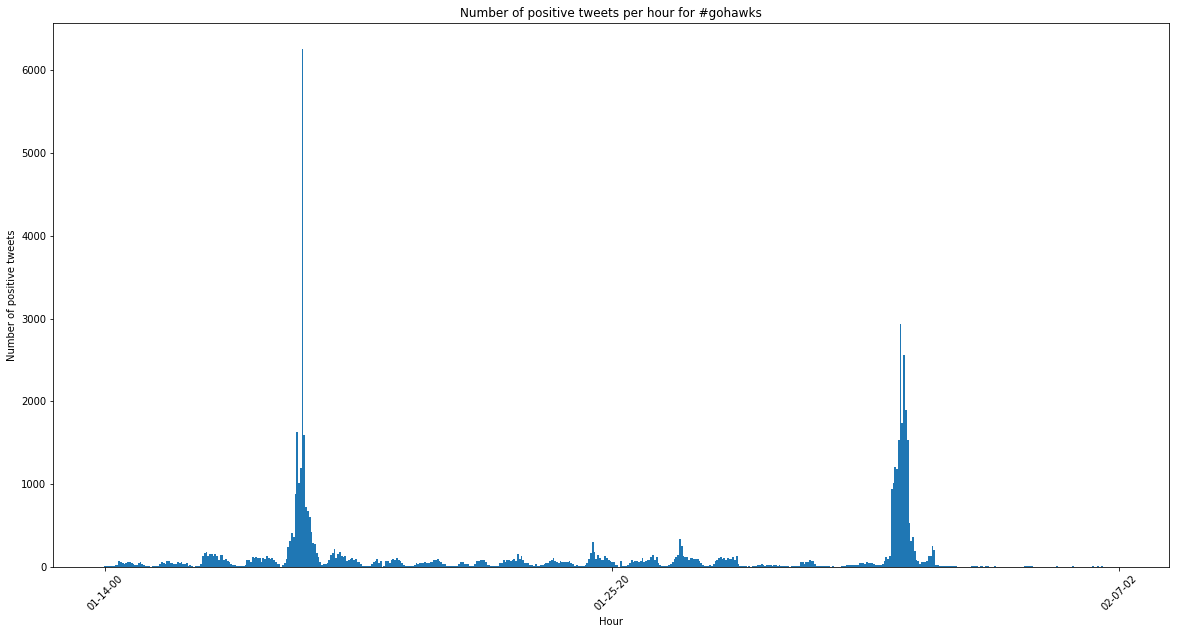

<Figure size 432x288 with 0 Axes>

In [ ]:
plot_num_tweets_per_hour('tweets_#gohawks.txt', '#gohawks')

## Below is just a test: Predict if a team won or lost based on the tweets sentiment
 It didn't work very well because we only have the data for one match.

In [8]:
import json

hashtags = ['gohawks', 'gopatriots']
#hashtags = ['gohawks']

data = {}

for hashtag in hashtags:
    file_name = 'tweets_#' + hashtag + '.txt'
    filestream = open(file_name, 'r', encoding = 'utf-8')
    
    tweets = []
    for line in filestream:
        tweet = json.loads(line)
        tweets.append(tweet)
        
    data[hashtag] = tweets
    filestream.close()

In [10]:
from textblob import TextBlob
import regex as re
import numpy as np

def cleanTweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

row = []

for hashtag in hashtags:
    len_2 = 0
    for tweet in data[hashtag]:  
        positives, negatives, retweets = 0, 0, 0
        tweet_analysis = TextBlob(cleanTweet(tweet['tweet']['text']))
        sentiment = tweet_analysis.sentiment.polarity
        
        if sentiment > 0:
            positives = 1
        elif sentiment < 0:
            negatives = 1
            
        retweets = tweet['metrics']['citations']['total']
        
        len_2 += 1
        
        temp = [positives, negatives, retweets]
        row.append(temp)  
    
X = np.array(row)
y = np.array([0] * len(X)) # Seahwaks lost
y[len(X)-len_2:len(X)] = 1 # Patriots won

In [26]:
print(X.shape)
print(y.shape)
print(len_2)

(192633, 3)
(192633,)
23511


In [19]:
from sklearn.metrics import auc, confusion_matrix, recall_score, roc_curve, precision_score, accuracy_score
from matplotlib import pyplot as plt
import itertools

def plot_roc(fpr, tpr):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)
    
    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.6', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)
    ax.set_title('ROC Curve')

    ax.legend(loc="lower right")

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

    plt.show()
    
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix without Normalization')
    print(cm)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '%.2f' % cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i,j]>thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def compute_and_plot_confusion_matrix(test_label, test_predicted, bclasses):
    cnf_matrix = confusion_matrix(test_label, test_predicted)
    np.set_printoptions(precision = 2)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes = bclasses, title = 'Confusion Matrix without Normalization')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes = bclasses, normalize = True, title = 'Normalized Confusion Matrix')
    plt.show()

C:\Users\nobod\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


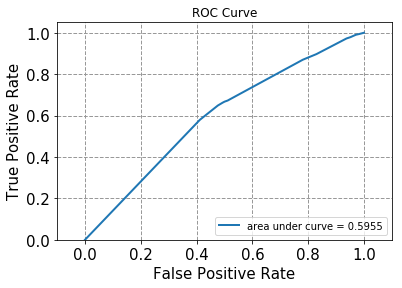

Confusion Matrix without Normalization
[[169122      0]
 [ 23511      0]]
Normalized Confusion Matrix
[[1. 0.]
 [1. 0.]]


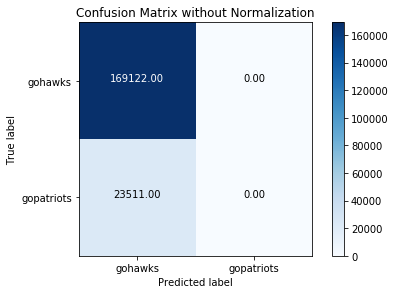

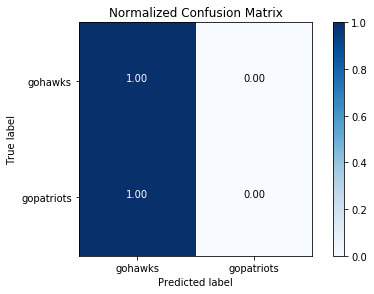

Accuracy: 0.8779492610300416
Recall: 0.0
Precision: 0.0


C:\Users\nobod\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression()
logistic.fit(X, y)

y_pred_prob = logistic.predict_proba(X)
y_pred = logistic.predict(X)

fpr, tpr, threshold = roc_curve(y, y_pred_prob[:,1])

plot_roc(fpr, tpr)
compute_and_plot_confusion_matrix(y, y_pred, hashtags)

accuracy = accuracy_score(y, y_pred)
print('Accuracy:',accuracy)

recall = recall_score(y, y_pred)
print('Recall:',recall)

precision = precision_score(y, y_pred)
print('Precision:',precision)